In [1]:
import pandas as pd
import numpy as np
import pandas_profiling 
import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_letters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import unidecode as uni
import time
import pickle
pd.set_option('display.max_columns', None)
with open('resultados_regresiones_revenue.pickle', 'rb') as handle:
    XGBRegressorRevenue = pickle.load(handle)
    
def Outliers(p_data, Desviacion):
    data_modificada = p_data
    
    # GENERO CULUMNA DE MEDIAS AGRUPANDO
    media__ = data_modificada.groupby(['RuntimeMinutes','Biography','Drama','Horror','revenue'])['Rate_x'].transform('mean')
    #GENERO COLUMNA DE STD AGRUPANDO
    str__ = data_modificada.groupby(['RuntimeMinutes','Biography','Drama','Horror','revenue',])['Rate_x'].transform('std')
    #GENERO COLUMNA CON LA FORMULA DE CHEUVENET PARA EL CALCULO DE OUTLIERS
    criterio_cheuvenet__ = (abs(data_modificada.Rate_x-media__))/(str__)

    data_modificada.Rate_x.loc[criterio_cheuvenet__>Desviacion] = np.nan
    return data_modificada 

/opt/conda/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
try:
    with open('resultados_regresiones_revenue.pickle', 'rb') as handle:
        XGBRegressorRevenue = pickle.load(handle)
except:
    from xgboost.sklearn import XGBRegressor,XGBClassifier
    export_data = pd.read_csv('export_data.csv',sep='|').iloc[:,1:]
    X = export_data.drop(['Title','revenue'],axis=1)
    y = export_data.revenue
    #from xgboost.sklearn import XGBRegressor,XGBClassifier
    XGBRegressor = XGBRegressor(alpha=0,max_depth=9,iterations=2,learning_rate=0.5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    XGBRegressorRevenue = XGBRegressor.fit(X_train,y_train)
    predict = XGBRegressorRevenue.predict(X_test)
    print('R2: '+str(r2_score(y_test,predict)))

## TRAER DATASET PELICULAS

In [3]:
data = pd.read_csv('data_movies_final.csv',sep='|').iloc[:,1:]
data['Rate'][data.Rate>10] = data.Rate[data.Rate>10]*0.10
data['fecha_mes'] = data['fecha'][data.fecha.notnull()]
dummies_meses = pd.get_dummies(data.fecha_mes[data.fecha_mes.notnull()].str.split(pat='-').apply(lambda x: x[1])).rename(columns={'01':'ENERO','02':'FEBRERO','03':'MARZO','04':'ABRIL','05':'MAYO','06':'JUNIO','07':'JULIO','08':'AGOSTO','09':'SEPTIEMBRE','10':'OCTUBRE','11':'NOVIEMBRE','12':'DICIEMBRE'})
data = pd.concat([data,dummies_meses],axis=1)
data = data[data.fecha_mes.notnull()]
data = data.drop(['IDDataLens','cant_baja_votos','cant_media_votos','cant_alta_votos','fecha_mes'],axis=1)
dataApropiado = pd.read_csv('data_apropiado.csv',sep='|').iloc[:,1:]
dataApropiado = dataApropiado.drop_duplicates()
data = data.merge(dataApropiado,how='left',left_on='Title',right_on='Title')
data['fecha_anio'] = data.fecha.str.split(pat='-').apply(lambda x: x[0])
data = data.drop(['popularity','largo_letras_titulo'],axis=1).drop_duplicates()
nuevaRate = pd.DataFrame(data.groupby(['Title'])['Rate'].mean()).reset_index()
data = data.merge(nuevaRate, how='left',left_on='Title',right_on='Title')
data['fecha_anio'] = data.fecha_anio.astype(int)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## QUITAMOS OUTLIERS RATE

In [4]:
data = Outliers(data,0.55)
data[data.Rate_x.notnull()]

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Budget,RuntimeMinutes,Title,Rate_x,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,revenue,fecha,ENERO,FEBRERO,MARZO,ABRIL,MAYO,JUNIO,JULIO,AGOSTO,SEPTIEMBRE,OCTUBRE,NOVIEMBRE,DICIEMBRE,apropiado,fecha_anio,Rate_y
2,30000000.0,98,wild bill,5.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1995-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1995,5.647059
3,30000000.0,98,wild bill,5.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,2011-10-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2011,5.647059
4,30000000.0,98,wild bill,6.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1995-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1995,5.647059
5,30000000.0,98,wild bill,6.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,2011-10-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2011,5.647059
22,3500000.0,87,the long ride home,5.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,2003-03-27,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2003,5.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184219,NaN,78,balto,7.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11348324.0,1995-12-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1995,6.820000
184220,NaN,78,balto,7.2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11348324.0,1995-12-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1995,6.820000
184224,45000000.0,84,chicken run,7.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,224834564.0,2000-06-21,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2000,7.542857
184227,45000000.0,84,chicken run,8.1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,224834564.0,2000-06-21,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2000,7.542857


## IMPUTAMOS REVENUE CON MODELO XGBOOST

In [5]:
data_predict = data.drop(['Title','Rate_x','revenue','fecha','Rate_y'],axis=1)
revenue_predicho = pd.Series(XGBRegressorRevenue.predict(data_predict))
data.revenue.update(revenue_predicho)
data = data.drop(['fecha','Rate_y'],axis=1)
data = data.dropna()
data = data.drop_duplicates()

## UNIR ¨PREMIOS DE ACTORES Y DIRECTORES

In [6]:
tecnicos_premios = pd.read_csv('df_tecnicos_premios.csv',sep='|').iloc[:,1:]
tecnicos_premios = tecnicos_premios.drop_duplicates()
data = data.merge(tecnicos_premios,how='left',left_on='Title',right_on='Title')
dummies_tecnicos = pd.get_dummies(data.FullName_y)
dummies_tecnicos = dummies_tecnicos.fillna(0)
dummies_tecnicos['otros_directores'] = dummies_tecnicos.sum(axis=1)
dummies_tecnicos['otros_directores'] = dummies_tecnicos['otros_directores'].apply(lambda x: 1 if x==0 else 0)
actores_premios = pd.read_csv('df_actores_premios.csv',sep='|').iloc[:,1:]
data = data.merge(actores_premios,how='left',left_on='Title',right_on='Title').drop(['Winner_x_y'],axis=1)
dummies_actores = pd.get_dummies(data.FullName)
dummies_actores = dummies_actores.fillna(0)
dummies_actores['otros_actores'] = dummies_actores.sum(axis=1)
dummies_actores['otros_actores'] = dummies_actores['otros_actores'].apply(lambda x: 1 if x==0 else 0)
df = pd.concat([data,dummies_tecnicos,dummies_actores],axis=1)
df.iloc[:,30:109] = df.iloc[:,30:109].fillna(0)
df['otros_directores'] = df.otros_directores.fillna(1)
df = df.drop(['FullName_y','FullName'],axis=1)

## CLASIFICAR SCORE

In [7]:
df = df.dropna()
df = df.drop_duplicates()
df = df.loc[:,~df.columns.duplicated()]
df = df[df.Rate_x>0]
df['Rate_x'] = pd.qcut(df.Rate_x,3,labels=[0,1,2])
df = df.dropna()
df = df.drop_duplicates()

## IMPORTAR LIBRERIAS SKLEARN

In [8]:
# Regressions
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDClassifier, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

# Boost Tuneados
from xgboost.sklearn import XGBRegressor,XGBClassifier
from catboost import CatBoostRegressor,CatBoostClassifier

In [9]:
def test_clasificadores_sklearn(p_X, p_y):
    
    modelos_clasificacion = [LogisticRegression(),
                             AdaBoostClassifier(),
                             GradientBoostingClassifier(),
                             RandomForestClassifier(),
                             XGBClassifier(),
                             CatBoostClassifier()]
    
    X = p_X
    y = p_y
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
    
    parametrosRegresionLogistica = {'solver':['lbfgs'],'random_state':[42],'max_iter':[20,50]}
    parametrosAdaBoostClassifier = {'random_state':[42],'n_estimators':[5,10,20,35]}
    parametrosGradientBoostingClassifier = {'random_state':[42],'n_estimators':[15],'max_depth':[15]}
    parametrosRandomForestClassifier = {'random_state':[42],'max_depth':[15,18],'n_estimators':[12,15]}
    parametrosXGBClassifier = {'max_depth':[15],'iterations':[5],'alpha':[0],'learning_rate':[0.9]}
    parametros_CatboostRegressor = {'max_depth':[10],'iterations':[25],'learning_rate':[1]}
    
    dicccionario_modelos = {0:'Regresion Logistica',1:'AdaBoostClassifier',2:'GradientBoostingClassifier',3:'RandomForestClassifier',4:'XGBClassifier',5:'CatBoostClassifier'}
    diccionario_parametros = {0:parametrosRegresionLogistica,1:parametrosAdaBoostClassifier,2:parametrosGradientBoostingClassifier,3:parametrosRandomForestClassifier,4:parametrosXGBClassifier,5:parametros_CatboostRegressor}    
    
    lista_indice = []
    lista_modelo = []
    lista_hiperparametros = []
    lista_accuracy = []
    lista_precision = []
    lista_recall = []
    lista_mat = []
    lista_tiempo = []
    lista_modelos_train = []
    
    for i, model in enumerate(modelos_clasificacion):
        start = pd.to_datetime(time.ctime())
        print('Clasificador: ',dicccionario_modelos[i])
        clf = GridSearchCV(model,diccionario_parametros[i])
        modelo = clf.fit(X_train, y_train)
        predicciones = modelo.predict(X_test)
        accuracy = accuracy_score(y_test, predicciones, normalize=True)
        precision = precision_score(y_test,predicciones,average='macro')
        recall = recall_score(y_test,predicciones,average='macro')

        lista_indice.append(i)
        lista_modelo.append(dicccionario_modelos[i])
        lista_hiperparametros.append(clf.best_params_)
        lista_accuracy.append(accuracy)
        lista_precision.append(precision)
        lista_recall.append(recall)
        
        print(classification_report(y_test,predicciones))
        print('')
        print(confusion_matrix(y_test,predicciones))
        lista_mat.append(confusion_matrix(y_test, predicciones))
        lista_modelos_train.append(modelo)
        end = pd.to_datetime(time.ctime())
        lista_tiempo.append(str((end-start).total_seconds()) + ' segundos')

        print('----------------------------------------------')
    
    return {'indices':lista_indice,'modelos':lista_modelo,'hiperparametros':lista_hiperparametros,'tiempo':lista_tiempo,'accuracy':lista_accuracy,'mat':lista_mat,'precision':lista_precision,'recall':lista_recall,'modelos_train':lista_modelos_train}

## SEPARO X y

In [9]:
X = df.drop(['Rate_x','Title'],axis=1)
y = df.Rate_x

## RESULTADOS ACCURACY RECALL PRECISION

In [ ]:
resultados_clasificadores = test_clasificadores_sklearn(X,y)
resultados = pd.DataFrame({'regresion':'Clasificadores','index':resultados_clasificadores['indices'],'nombre':resultados_clasificadores['modelos'],'gridsearchcv':resultados_clasificadores['hiperparametros'],'tiempo':resultados_clasificadores['tiempo'],'accuracy':resultados_clasificadores['accuracy'],'precision':resultados_clasificadores['precision'],'recall':resultados_clasificadores['recall'],'modelos':resultados_clasificadores['modelos_train']})
resultados

In [ ]:
resultados

## GUARDO MODELOS EN PICKLE

In [ ]:
#with open('resultados_clasificadores_rate.pickle', 'wb') as handle:
#    pickle.dump(resultados_clasificadores, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('resultados_rate.pickle', 'wb') as handle:
#    pickle.dump(resultados, handle, protocol=pickle.HIGHEST_PROTOCOL)

## LEVANTO PICKLE CON MODELOS YA ENTRENADOS

In [ ]:
#with open('resultados_clasificadores_rate.pickle', 'rb') as handle:
#    resultados_clasificadores = pickle.load(handle)
#with open('resultados_rate.pickle', 'rb') as handle:
#    resultados = pickle.load(handle)

## MATRIZ DE RESULTADOS 

In [11]:
plt.figure(figsize=(15,15))
mat = resultados_clasificadores['mat'][0]
sns.heatmap(mat, square=True, annot=True, fmt='d',linewidths=5)
plt.title(resultados_clasificadores['modelos'][0])
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')

NameError: name 'resultados_clasificadores' is not defined

<Figure size 1080x1080 with 0 Axes>

In [ ]:
plt.figure(figsize=(15,15))
mat = resultados_clasificadores['mat'][1]
sns.heatmap(mat, square=True, annot=True, fmt='d',linewidths=5)
plt.title(resultados_clasificadores['modelos'][1])
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')

In [ ]:
plt.figure(figsize=(15,15))
mat = resultados_clasificadores['mat'][2]
sns.heatmap(mat, square=True, annot=True, fmt='d',linewidths=5)
plt.title(resultados_clasificadores['modelos'][2])
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')

In [ ]:
plt.figure(figsize=(15,15))
mat = resultados_clasificadores['mat'][3]
sns.heatmap(mat, square=True, annot=True, fmt='d',linewidths=5)
plt.title(resultados_clasificadores['modelos'][3])
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')

In [ ]:
plt.figure(figsize=(15,15))
mat = resultados_clasificadores['mat'][4]
sns.heatmap(mat, square=True, annot=True, fmt='d',linewidths=5)
plt.title(resultados_clasificadores['modelos'][4])
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')

## ANALISIS DE RESULTADOS

In [ ]:
resultados

In [10]:
from xgboost.sklearn import XGBRegressor,XGBClassifier
XGBClassifier = XGBClassifier(max_depth=15,iterations=5,alpha=0,learning_rate=0.9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
XGBClassifier = XGBClassifier.fit(X_train,y_train)
predict = XGBClassifier.predict(X_test)
print(accuracy_score(y_test, predict, normalize=True))
print(precision_score(y_test,predict,average='macro'))
print(recall_score(y_test,predict,average='macro'))
import lime
import lime.lime_tabular
df_new = X_test

0.6638191478278987
0.6627650237126915
0.6630730014065312


In [11]:
#df_array = df_new
df_array = df_new.sample(1)
predict = XGBClassifier.predict_proba(df_array)
import shap  
shap.initjs()

In [12]:
predict

array([[9.98883307e-01, 1.10193074e-03, 1.48036115e-05]], dtype=float32)

## ESTADISTICAS DICAPRIO

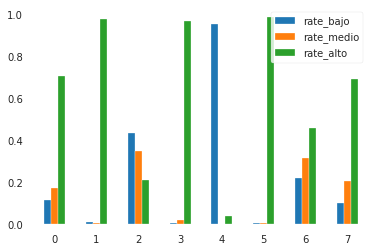

In [53]:
estadisticas_diCaprio = pd.read_csv('estadisticas_diCaprio.csv',sep='|').iloc[:,1:]
estadisticas_diCaprio.plot.bar(rot=0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f28494ac358>,
      dtype=object)

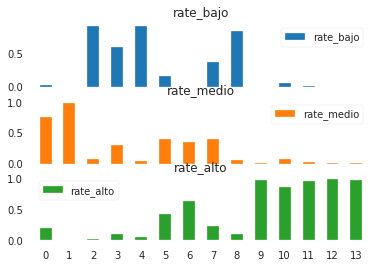

In [54]:
df_tiempo = pd.read_csv('predicciones_rate_tiempo_pelicula.csv',sep='|').iloc[:,1:]
df_tiempo.plot.bar(rot=0,subplots=True)

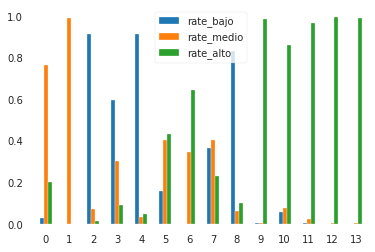

In [55]:
df_tiempo.plot.bar(rot=0,subplots=False)

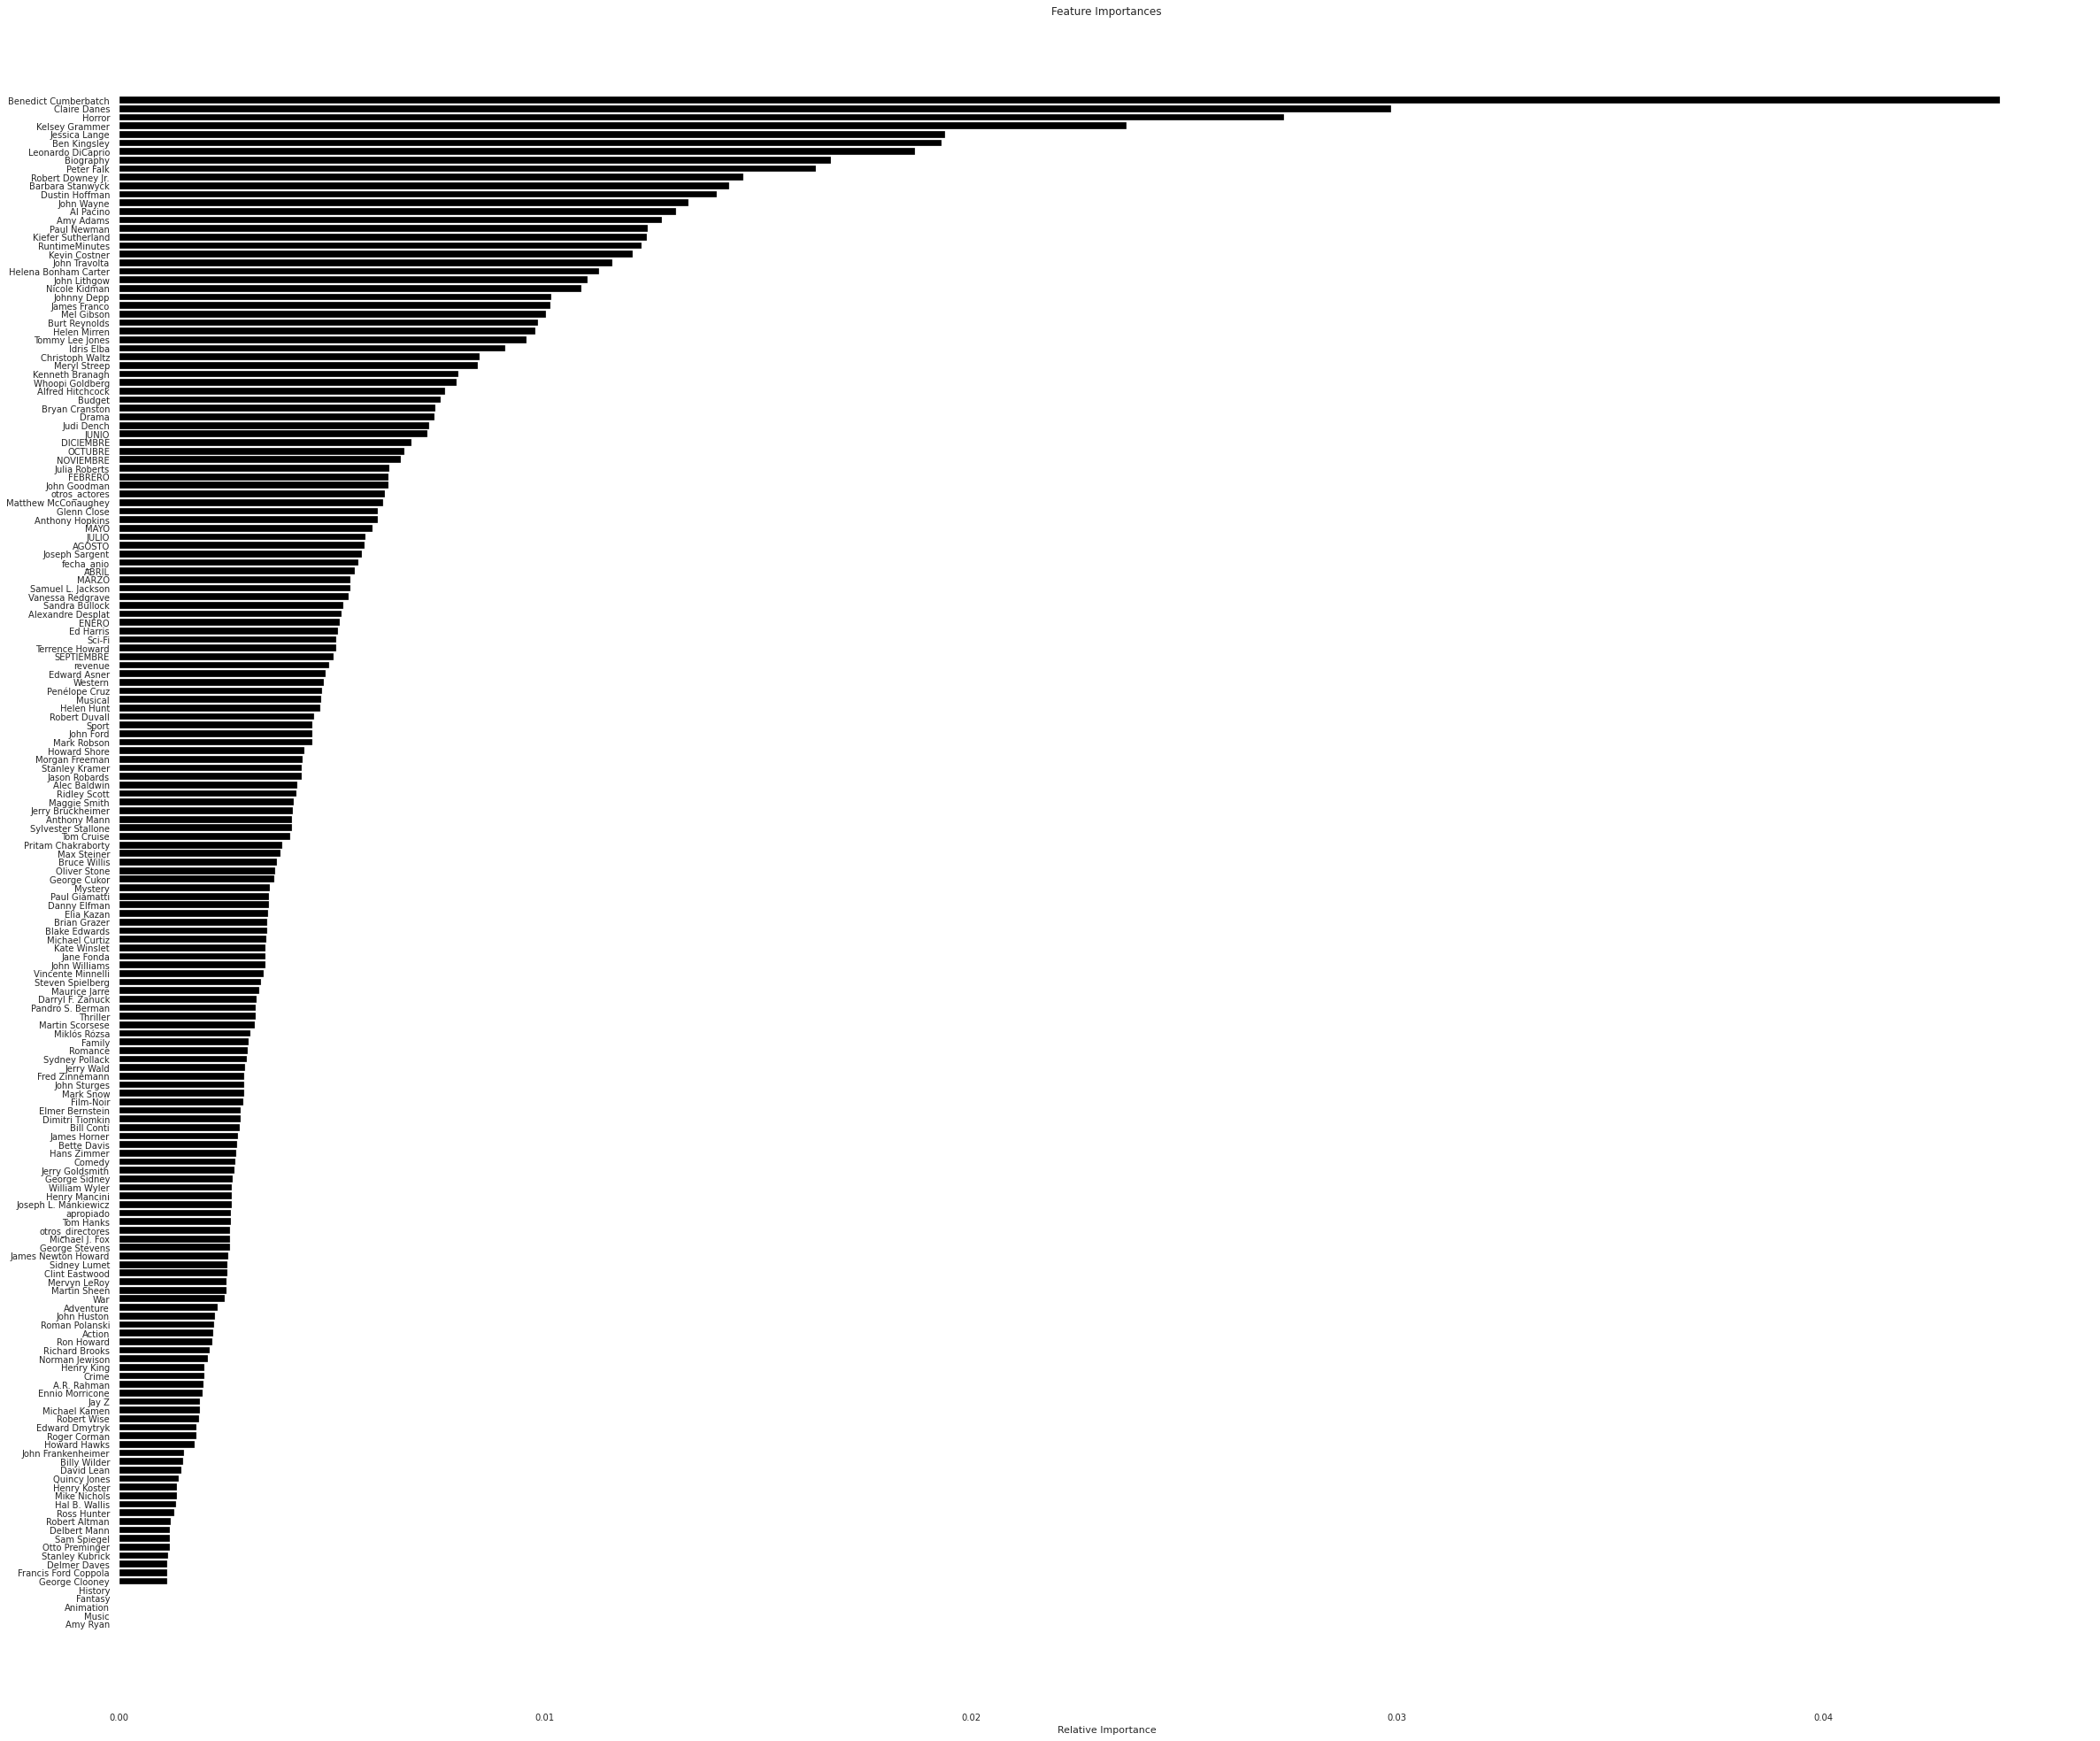

In [56]:
plt.figure(figsize=(40,35))
importances = XGBClassifier.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='black',tick_label='1', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [13]:
explainer = shap.TreeExplainer(XGBClassifier)
shap_values = explainer.shap_values(df_array)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [14]:
index = XGBClassifier.predict(df_array)[0]
etiquete_rate = {0:'Prediccion Rate Bajo',1:'Prediccion Rate Medio',2:'Prediccion Rate Alto'}

In [15]:
df_array

,Budget,RuntimeMinutes,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,revenue,ENERO,FEBRERO,MARZO,ABRIL,MAYO,JUNIO,JULIO,AGOSTO,SEPTIEMBRE,OCTUBRE,NOVIEMBRE,DICIEMBRE,apropiado,fecha_anio,A.R. Rahman,Alexandre Desplat,Alfred Hitchcock,Anthony Mann,Bill Conti,Billy Wilder,Blake Edwards,Brian Grazer,Clint Eastwood,Danny Elfman,Darryl F. Zanuck,David Lean,Delbert Mann,Delmer Daves,Dimitri Tiomkin,Edward Dmytryk,Elia Kazan,Elmer Bernstein,Ennio Morricone,Francis Ford Coppola,Fred Zinnemann,George Clooney,George Cukor,George Sidney,George Stevens,Hal B. Wallis,Hans Zimmer,Henry King,Henry Koster,Henry Mancini,Howard Hawks,Howard Shore,James Horner,James Newton Howard,Jay Z,Jerry Bruckheimer,Jerry Goldsmith,Jerry Wald,John Ford,John Frankenheimer,John Huston,John Sturges,John Williams,Joseph L. Mankiewicz,Joseph Sargent,Kenneth Branagh,Mark Robson,Mark Snow,Martin Scorsese,Maurice Jarre,Max Steiner,Mervyn LeRoy,Michael Curtiz,Michael Kamen,Mike Nichols,Miklós Rózsa,Norman Jewison,Oliver Stone,Otto Preminger,Pandro S. Berman,Pritam Chakraborty,Quincy Jones,Richard Brooks,Ridley Scott,Robert Altman,Robert Wise,Roger Corman,Roman Polanski,Ron Howard,Ross Hunter,Sam Spiegel,Sidney Lumet,Stanley Kramer,Stanley Kubrick,Steven Spielberg,Sydney Pollack,Tom Hanks,Vincente Minnelli,William Wyler,otros_directores,Al Pacino,Alec Baldwin,Amy Adams,Amy Ryan,Anthony Hopkins,Barbara Stanwyck,Ben Kingsley,Benedict Cumberbatch,Bette Davis,Bruce Willis,Bryan Cranston,Burt Reynolds,Christoph Waltz,Claire Danes,Dustin Hoffman,Ed Harris,Edward Asner,Glenn Close,Helen Hunt,Helen Mirren,Helena Bonham Carter,Idris Elba,James Franco,Jane Fonda,Jason Robards,Jessica Lange,John Goodman,John Lithgow,John Travolta,John Wayne,Johnny Depp,Judi Dench,Julia Roberts,Kate Winslet,Kelsey Grammer,Kevin Costner,Kiefer Sutherland,Leonardo DiCaprio,Maggie Smith,Martin Sheen,Matthew McConaughey,Mel Gibson,Meryl Streep,Michael J. Fox,Morgan Freeman,Nicole Kidman,Paul Giamatti,Paul Newman,Penélope Cruz,Peter Falk,Robert Downey Jr.,Robert Duvall,Samuel L. Jackson,Sandra Bullock,Sylvester Stallone,Terrence Howard,Tom Cruise,Tommy Lee Jones,Vanessa Redgrave,Whoopi Goldberg,otros_actores
25776,25000000.0,87,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45603712.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [64]:
shap.force_plot(explainer.expected_value[index], shap_values[index], df_array,feature_names=features,out_names=[etiquete_rate[index]],link="logit")

In [ ]:
explainer = shap.TreeExplainer(XGBClassifier)
shap_values = explainer.shap_values(X_test.sample(1000))

In [ ]:
shap.summary_plot(shap_values[0], X_test.sample(1000), plot_type="bar",color='black')

In [ ]:
labels=['Rate Bajo','Rate Medio','Rate Alto']
shap.summary_plot(shap_values, X_test.sample(1000),class_names=labels)

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0],X)